# Processing of Molpro output files
**Author**: Egor Trushin  
**Date created:** 24/01/2024  
**Last modified:** 26/01/2024  
**Description:** This notebook processes Molpro output files. Processed data are stored in Python-friendly formats. Data inspection is also performed.

In [1]:
import copy
import json
import os
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["axes.unicode_minus"] = False

In [2]:
os.makedirs("CLEAN_DATA", exist_ok=True)

## Auxiliary functions

In [3]:
def bold_text(text): return "\033[1m" + text + "\033[0m"

In [4]:
def parse_en(filename, keyword):
    """Parse energy from SCEXX/USCEXX/KSINV/UKSINV output using keyword."""
    energy = None
    for line in open(filename, "r", encoding="utf-8"):
        if "NOT" in line:
            energy = None
        if keyword in line:
            energy = float(line.split()[-1])
    return energy

In [5]:
def parse_eigenvalues(outfile, keyword):
    """Parse eigenvalues from SCEXX/USCEXX/KSINV/UKSINV output using keyword."""
    eigs = []
    i = 10000
    for line in open(outfile):
        if "NOT" in line:
            return None
        if keyword in line:
            i = 0
        if i < 3:
            if i > 0:
                for j in line.split()[2:]:
                    eigs.append(float(j))
            i+=1
        if i==3:
            i=10000
    return eigs

In [6]:
def check_swap(outfile):
    """Determine whether orbital swap is applied and return swapped orbitals."""
    swap = None
    for line in open(outfile):
        if "orbitals to swap:" in line:
            aux = line.split()
            swap = [int(aux[-2]), int(aux[-1])]
    return swap

In [7]:
def load_vx(filename):
    """Reads exchange potentials from file provided by Molpro."""
    coord = list()
    pot = list()
    for line in open(filename):
        aux = line.split()
        coord.append(float(aux[4]))
        pot.append(float(aux[8]))
    return [coord, pot]

In [8]:
def parse_eigenvalues_hf(outfile):
    """Reads eigenvalues from HF output."""
    lprint = 0
    aux_string = ""
    for line in open(outfile, "r", encoding="utf-8"):
        if lprint == 1:
            lprint = 2
        if "Orbital energies:" in line:
            lprint = 1
        if "HOMO" in line:
            lprint = 0
        if lprint == 2 and line not in ["\n", "\r\n"]:
            aux_string += line
    eigs = []
    for el in aux_string.split("\n")[1::2]:
        eigs.extend(el.split())
    eigs = [float(i) for i in eigs]
    return eigs

In [9]:
def parse_density_error(filename, normalize=True):
    """Parse density error from KSINV output."""
    density_error = None
    for line in open(filename, "r", encoding="utf-8"):
        if "NOT" in line:
            density_error = None
        if "Full-Density Test" in line:
            if normalize:
                density_error = float(line.split()[2])/float(line.split()[3])
            else:
                density_error = float(line.split()[2])
    return density_error

In [10]:
def load_vxc_den_ksinv(filename, xyz=3):
    """Reads potentials/densities from file provided by KSINV."""
    coord = list()
    pot = list()
    for line in open(filename):
        aux = line.split()
        coord.append(float(aux[xyz-1]))
        pot.append(float(aux[3]))
    return [coord, pot]

In [11]:
def parse_exx_gaps(outfile):
    """Parse HOMO-LUMO gaps from EXX output."""
    gap_alpha = None
    gap_beta = None
    l_problem = False
    for line in open(outfile):
        if "LUMO-HOMO (alpha):" in line:
            gap_alpha = float(line.split()[-1])
        if "LUMO-HOMO (beta):" in line:
            gap_beta = float(line.split()[-1])
        if "SCF NOT" in line:
            l_problem = True
    if l_problem:
        gap_alpha = None
        gap_beta = None
    return gap_alpha, gap_beta

In [12]:
def parse_ksinv_gaps(outfile):
    """Parse HOMO-LUMO gaps from KSINV output."""
    gap_alpha = None
    gap_beta = None
    l_problem = False
    for line in open(outfile):
        if "LUMO-HOMO:" in line:
            gap_alpha = float(line.split()[-2])
            gap_beta = float(line.split()[-1])    
        if "SCF NOT" in line:
            l_problem = True
    if l_problem:
        gap_alpha = None
        gap_beta = None
    return gap_alpha, gap_beta

## Processing of total energies from EXX calculations for all four symmetry cases

In [13]:
DATA_PATH = "RAW_OUTPUTS/EXX"
SYSTEMS = ["B", "C", "N", "O", "F", "Al", "Si", "P", "S", "Cl"]
SYMMETRY = ["NonSym", "SpaceSym", "SpinSym", "FullSym"]

In [14]:
# Collect EXX total energies
results = {}
for system in SYSTEMS:
    results_system = {}
    for sym in SYMMETRY:
        outfile = os.path.join(DATA_PATH, system, sym, "output")
        results_system[sym] = parse_en(outfile, "USCEXX Total energy")
    results[system] = results_system

In [15]:
# Save EXX total energies to json file
with open('CLEAN_DATA/EXX_total_energies_all_sym_cases.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [16]:
# Print EXX total energies
print("Atom    Non-Sym.    Space-Sym.     Spin-Sym.     Full-Sym.")
for system in SYSTEMS:
    e_nonsym = f"{results[system]['NonSym']:11.6f}"
    e_spacesym = f"{results[system]['SpaceSym']:11.6f}"
    e_spinsym = f"{results[system]['SpinSym']:11.6f}"
    if system in ["O", "F", "S", "Cl"]:
        e_spinsym = bold_text(e_spinsym)
    e_fullsym = f"{results[system]['FullSym']:11.6f}"
    print(f"{system:2}   {e_nonsym}   {e_spacesym}   {e_spinsym}   {e_fullsym}")

Atom    Non-Sym.    Space-Sym.     Spin-Sym.     Full-Sym.
B     -24.531363    -24.527885    -24.527595    -24.527347
C     -37.691836    -37.688661    -37.686554    -37.686327
N     -54.403208    -54.403208    -54.397950    -54.397950
O     -74.816730    -74.811545    -74.808660    -74.807403
F     -99.413727    -99.408770    -99.408278    -99.407436
Al   -241.877082   -241.873319   -241.873464   -241.873229
Si   -288.854178   -288.850027   -288.849692   -288.849501
P    -340.714135   -340.714135   -340.712837   -340.712837
S    -397.507365   -397.500464   -397.499841   -397.498967
Cl   -459.483425   -459.476559   -459.476703   -459.476057


## Processing of orbital energies and potentials from spin-symmetrized EXX calculations

In [17]:
DATA_PATH = "RAW_OUTPUTS/EXX_SpinSym_plot"
SYSTEMS = ["B", "C", "N", "O", "F", "Al", "Si", "P", "S", "Cl"]

In [18]:
# Collect eigenvalues
results = {}
for system in SYSTEMS:
    outfile = os.path.join(DATA_PATH, system, "output")
    results[system] = {}
    results[system]["eigenvalues"] = sorted(parse_eigenvalues(outfile, "USCEXX eigenvalues (alpha)"))

In [19]:
# Determine occupation numbers and supplement to results
with open("json/atoms.json", "r") as file_obj:
    atoms = json.load(file_obj)

for system in SYSTEMS:
    na = atoms[system]["na"]
    nb = atoms[system]["nb"]
    neigs = len(results[system]["eigenvalues"])
    occa = [1]*na
    occa.extend([0]*(neigs-na))
    occb = [1]*nb
    occb.extend([0]*(neigs-nb))
    if system in ["O", "F"]:
        occb[2] = 0
        occb[4] = 1
    if system in ["S", "Cl"]:
        occb[6] = 0
        occb[8] = 1
    occ = [occa[i]+occb[i] for i in range(len(occa))]
    results[system]["occ"] = occ

In [20]:
# Save data to json file
with open('CLEAN_DATA/EXX_SpinSym_eigenvalues.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [21]:
# Print occupation numbers and eigenvalues
print(f'{" "*4} B {" "*12} C {" "*12} N {" "*12} O {" "*12} F')
for i in range(5):
    B = f'{results["B"]["occ"][i]} {results["B"]["eigenvalues"][i]:8.3f}'
    C = f'{results["C"]["occ"][i]} {results["C"]["eigenvalues"][i]:8.3f}'
    N = f'{results["N"]["occ"][i]} {results["N"]["eigenvalues"][i]:8.3f}'
    O = f'{results["O"]["occ"][i]} {results["O"]["eigenvalues"][i]:8.3f}'
    F = f'{results["F"]["occ"][i]} {results["F"]["eigenvalues"][i]:8.3f}'
    print(f"{B:14} {C:14} {N:14} {O:14} {F:14}")

print(f'\n{" "*4} Al {" "*11} Si {" "*11} P {" "*12} S {" "*12} Cl')
for i in range(9):
    Al = f'{results["Al"]["occ"][i]} {results["Al"]["eigenvalues"][i]:8.3f}'
    Si = f'{results["Si"]["occ"][i]} {results["Si"]["eigenvalues"][i]:8.3f}'
    P = f'{results["P"]["occ"][i]} {results["P"]["eigenvalues"][i]:8.3f}'
    S = f'{results["S"]["occ"][i]} {results["S"]["eigenvalues"][i]:8.3f}'
    Cl = f'{results["Cl"]["occ"][i]} {results["Cl"]["eigenvalues"][i]:8.3f}'
    print(f"{Al:14} {Si:14} {P:14} {S:14} {Cl:14}")

     B              C              N              O              F
2   -6.851     2  -10.297     2  -14.391     2  -19.179     2  -24.630    
2   -0.488     2   -0.705     2   -0.936     2   -1.150     2   -1.383    
1   -0.274     1   -0.389     1   -0.501     1   -0.596     1   -0.696    
0   -0.268     1   -0.389     1   -0.501     1   -0.596     2   -0.667    
0   -0.268     0   -0.380     1   -0.501     2   -0.568     2   -0.667    

     Al             Si             P              S              Cl
2  -55.549     2  -65.661     2  -76.573     2  -88.325     2 -100.930    
2   -4.163     2   -5.332     2   -6.600     2   -7.971     2   -9.462    
2   -2.736     2   -3.715     2   -4.784     2   -5.963     2   -7.260    
2   -2.736     2   -3.708     2   -4.784     2   -5.963     2   -7.243    
2   -2.731     2   -3.708     2   -4.784     2   -5.947     2   -7.243    
2   -0.382     2   -0.510     2   -0.650     2   -0.769     2   -0.902    
1   -0.204     1   -0.267     1   -0.34

In [22]:
# Collect HOMO-LUMO gaps
results = {}
for system in SYSTEMS:
    outfile = os.path.join(DATA_PATH, system, "output")
    a, b = parse_exx_gaps(outfile)
    results[system] = {"a": a, "b": b}

In [23]:
# Save data to json file
with open('CLEAN_DATA/EXX_SpinSym_gaps.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [24]:
# Collect exchange potentials
vx = {}
for system in SYSTEMS:
    vx[system] = {}
    potfile = os.path.join(DATA_PATH, system, "vxa-final.x")
    vx_x = load_vx(potfile)
    vx[system]["x"] = vx_x
    potfile = os.path.join(DATA_PATH, system, "vxa-final.y")
    vx_y = load_vx(potfile)
    vx[system]["y"] = vx_y
    potfile = os.path.join(DATA_PATH, system, "vxa-final.z")
    vx_z = load_vx(potfile)
    vx[system]["z"] = vx_z

In [25]:
# Save pickle file with potentials
with open('CLEAN_DATA/EXX_SpinSym_vx.pkl', "wb") as output_file:
    pickle.dump(vx, output_file)

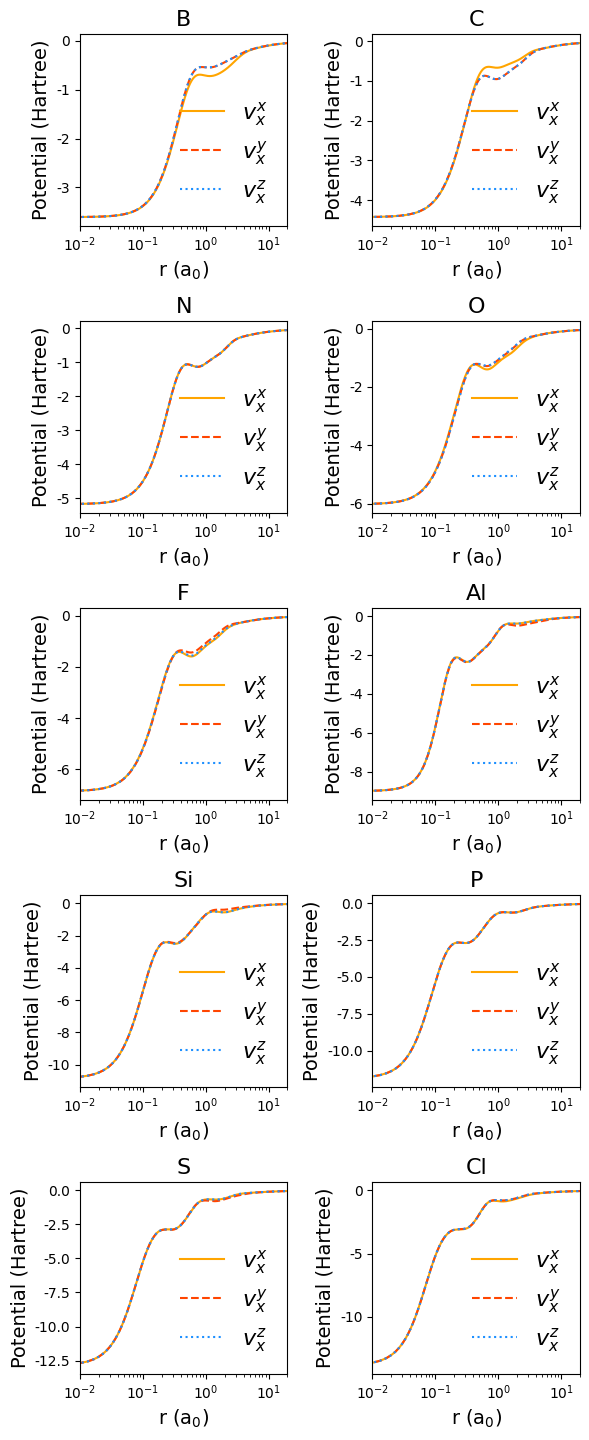

In [26]:
# Plot exchange potentials
fig, axs = plt.subplots(5, 2, figsize=(6,14.5))
    
for i, s in enumerate(SYSTEMS):
    
    axs.flatten()[i].set_title(f"{s}", fontsize=16)

    axs.flatten()[i].set_ylabel('Potential (Hartree)', fontsize=14)
    axs.flatten()[i].set_xlabel('r (a$_0$)', fontsize=14)
    axs.flatten()[i].set_xlim(0.01, 20.0)
    axs.flatten()[i].set_xscale("log")
    
    coord = vx[s]["x"][0]
    pot = vx[s]["x"][1]
    axs.flatten()[i].plot(coord, pot, '-', color="orange", label=r'$v_{x}^x$')

    coord = vx[s]["y"][0]
    pot = vx[s]["y"][1]
    axs.flatten()[i].plot(coord, pot, '--', color="orangered", label=r'$v_{x}^y$')
    
    coord = vx[s]["z"][0]
    pot = vx[s]["z"][1]
    axs.flatten()[i].plot(coord, pot, ':', color="dodgerblue", label=r'$v_{x}^z$')

    axs.flatten()[i].legend(frameon=False, fontsize=16, loc=4)
        
plt.tight_layout()
plt.show()

## Processing of ROHF calculations

In [27]:
DATA_PATH = "RAW_OUTPUTS/ROHF"
SYSTEMS = ["B", "C", "N", "O", "F", "Al", "Si", "P", "S", "Cl"]

In [28]:
# Parse eigenvalues
results = {}
for system in SYSTEMS:
    outfile = os.path.join(DATA_PATH, system, "output")
    results[system] = {}
    results[system]["eigenvalues"] = sorted(parse_eigenvalues_hf(outfile))

In [29]:
# Determine occupation numbers and supplement to results
with open("json/atoms.json", "r") as file_obj:
    atoms = json.load(file_obj)

for system in SYSTEMS:
    na = atoms[system]["na"]
    nb = atoms[system]["nb"]
    neigs = len(results[system]["eigenvalues"])
    occa = [1]*na
    occa.extend([0]*(neigs-na))
    occb = [1]*nb
    occb.extend([0]*(neigs-nb))
    if system in ["O", "F"]:
        occb[2] = 0
        occb[4] = 1
    if system in ["S", "Cl"]:
        occb[6] = 0
        occb[8] = 1
    occ = [occa[i]+occb[i] for i in range(len(occa))]
    results[system]["occ"] = occ

In [30]:
# Save data to json file
with open('CLEAN_DATA/ROHF_eigenvalues.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [31]:
# Print occupation numbers and eigenvalues
print(f'{" "*4} B {" "*12} C {" "*12} N {" "*12} O {" "*12} F')
for i in range(5):
    B = f'{results["B"]["occ"][i]} {results["B"]["eigenvalues"][i]:8.3f}'
    C = f'{results["C"]["occ"][i]} {results["C"]["eigenvalues"][i]:8.3f}'
    N = f'{results["N"]["occ"][i]} {results["N"]["eigenvalues"][i]:8.3f}'
    O = f'{results["O"]["occ"][i]} {results["O"]["eigenvalues"][i]:8.3f}'
    F = f'{results["F"]["occ"][i]} {results["F"]["eigenvalues"][i]:8.3f}'
    print(f"{B:14} {C:14} {N:14} {O:14} {F:14}")

print(f'\n{" "*4} Al {" "*11} Si {" "*11} P {" "*12} S {" "*12} Cl')
for i in range(9):
    Al = f'{results["Al"]["occ"][i]} {results["Al"]["eigenvalues"][i]:8.3f}'
    Si = f'{results["Si"]["occ"][i]} {results["Si"]["eigenvalues"][i]:8.3f}'
    P = f'{results["P"]["occ"][i]} {results["P"]["eigenvalues"][i]:8.3f}'
    S = f'{results["S"]["occ"][i]} {results["S"]["eigenvalues"][i]:8.3f}'
    Cl = f'{results["Cl"]["occ"][i]} {results["Cl"]["eigenvalues"][i]:8.3f}'
    print(f"{Al:14} {Si:14} {P:14} {S:14} {Cl:14}")

     B              C              N              O              F
2   -7.695     2  -11.326     2  -15.629     2  -20.669     2  -26.383    
2   -0.495     2   -0.706     2   -0.945     2   -1.245     2   -1.573    
1   -0.310     1   -0.433     1   -0.568     1   -0.703     1   -0.834    
0    0.020     1   -0.433     1   -0.568     1   -0.703     2   -0.706    
0    0.020     0    0.011     1   -0.568     2   -0.567     2   -0.706    

     Al             Si             P              S              Cl
2  -58.501     2  -68.812     2  -79.970     2  -92.005     2 -104.884    
2   -4.911     2   -6.157     2   -7.511     2   -9.005     2  -10.608    
2   -3.219     2   -4.257     2   -5.401     2   -6.683     2   -8.074    
2   -3.219     2   -4.256     2   -5.401     2   -6.683     2   -8.072    
2   -3.218     2   -4.256     2   -5.401     2   -6.682     2   -8.072    
2   -0.393     2   -0.540     2   -0.696     2   -0.880     2   -1.073    
1   -0.210     1   -0.297     1   -0.39

## Processing of CAHF calculations

In [32]:
DATA_PATH = "RAW_OUTPUTS/CAHF"
SYSTEMS = ["B", "C", "N", "O", "F", "Al", "Si", "P", "S", "Cl"]

In [33]:
# Parse eigenvalues
results = {}
for system in SYSTEMS:
    outfile = os.path.join(DATA_PATH, system, "output")
    results[system] = {}
    results[system]["eigenvalues"] = parse_eigenvalues_hf(outfile)

In [34]:
# Determine occupation numbers and supplement to results
with open("json/atoms.json", "r") as file_obj:
    atoms = json.load(file_obj)

for system in SYSTEMS:
    na = atoms[system]["na"]
    nb = atoms[system]["nb"]
    neigs = len(results[system]["eigenvalues"])
    occa = [1]*na
    occa.extend([0]*(neigs-na))
    occb = [1]*nb
    occb.extend([0]*(neigs-nb))
    occ = [occa[i]+occb[i] for i in range(len(occa))]
    results[system]["occ"] = occ

In [35]:
# Save data to json file
with open('CLEAN_DATA/CAHF_eigenvalues.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [36]:
# Print occupation numbers and eigenvalues
print(f'{" "*4} B {" "*12} C {" "*12} N {" "*12} O {" "*12} F')
for i in range(5):
    B = f'{results["B"]["occ"][i]} {results["B"]["eigenvalues"][i]:8.3f}'
    C = f'{results["C"]["occ"][i]} {results["C"]["eigenvalues"][i]:8.3f}'
    N = f'{results["N"]["occ"][i]} {results["N"]["eigenvalues"][i]:8.3f}'
    O = f'{results["O"]["occ"][i]} {results["O"]["eigenvalues"][i]:8.3f}'
    F = f'{results["F"]["occ"][i]} {results["F"]["eigenvalues"][i]:8.3f}'
    print(f"{B:14} {C:14} {N:14} {O:14} {F:14}")

print(f'\n{" "*4} Al {" "*11} Si {" "*11} P {" "*12} S {" "*12} Cl')
for i in range(9):
    Al = f'{results["Al"]["occ"][i]} {results["Al"]["eigenvalues"][i]:8.3f}'
    Si = f'{results["Si"]["occ"][i]} {results["Si"]["eigenvalues"][i]:8.3f}'
    P = f'{results["P"]["occ"][i]} {results["P"]["eigenvalues"][i]:8.3f}'
    S = f'{results["S"]["occ"][i]} {results["S"]["eigenvalues"][i]:8.3f}'
    Cl = f'{results["Cl"]["occ"][i]} {results["Cl"]["eigenvalues"][i]:8.3f}'
    print(f"{Al:14} {Si:14} {P:14} {S:14} {Cl:14}")

     B              C              N              O              F
2   -7.737     2  -11.338     2  -15.666     2  -20.681     2  -26.383    
2   -0.408     2   -0.712     2   -0.964     2   -1.250     2   -1.573    
1   -0.221     1   -0.271     1   -0.509     2   -0.822     2   -1.217    
0   -0.221     1   -0.271     1   -0.509     1   -0.822     2   -1.217    
0   -0.221     0   -0.271     1   -0.509     1   -0.822     1   -1.217    

     Al             Si             P              S              Cl
2  -58.589     2  -68.819     2  -79.989     2  -92.011     2 -104.884    
2   -4.990     2   -6.163     2   -7.529     2   -9.010     2  -10.608    
2   -3.307     2   -4.262     2   -5.418     2   -6.688     2   -8.072    
2   -3.307     2   -4.262     2   -5.418     2   -6.688     2   -8.072    
2   -3.307     2   -4.262     2   -5.418     2   -6.688     2   -8.072    
2   -0.331     2   -0.544     2   -0.706     2   -0.883     2   -1.073    
1   -0.165     1   -0.186     1   -0.35

## Processing of KSINV calculations (ROHF)

In [37]:
DATA_PATH = "RAW_OUTPUTS/KSINV_ROHF"
SYSTEMS = ["B", "C", "N", "O", "F", "Al", "Si", "P", "S", "Cl"]
REFERENCE = ["RS2", "CISD", "AQCC"]

In [38]:
# Parse eigenvalues
results = {}
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        results[system][ref] = {}
        outfile = os.path.join(DATA_PATH, ref, system, "output")
        results[system][ref]["eigenvalues"] = parse_eigenvalues(outfile, "KSINV eigenvalues")

In [39]:
# Determine occupation numbers and supplement to results
with open("json/atoms.json", "r") as file_obj:
    atoms = json.load(file_obj)

for system in SYSTEMS:
    for ref in REFERENCE:
        na = atoms[system]["na"]
        nb = atoms[system]["nb"]
        if results[system][ref]["eigenvalues"] is not None:
            neigs = len(results[system][ref]["eigenvalues"])
        else:
            neigs = 10000
        occa = [1]*na
        occa.extend([0]*(neigs-na))
        occb = [1]*nb
        occb.extend([0]*(neigs-nb))
        occ = [occa[i]+occb[i] for i in range(len(occa))]
        results[system][ref]["occ"] = occ

        if system in ["B", "C", "O", "F"]:
            if results[system][ref]["eigenvalues"][2] > results[system][ref]["eigenvalues"][4]:
                if system in ["B", "C"]:
                    occa[2] = 0
                    occa[4] = 1
                else:
                    occb[2] = 0
                    occb[4] = 1
                results[system][ref]["eigenvalues"] = sorted(results[system][ref]["eigenvalues"])
        if system in ["Al", "Si", "S", "Cl"] and results[system][ref]["eigenvalues"] is not None:
            if results[system][ref]["eigenvalues"][6] > results[system][ref]["eigenvalues"][8]:
                if system in ["Al", "Si"]:
                    occa[6] = 0
                    occa[8] = 1
                else:
                    occb[6] = 0
                    occb[8] = 1
                results[system][ref]["eigenvalues"] = sorted(results[system][ref]["eigenvalues"])
        occ = [occa[i]+occb[i] for i in range(len(occa))]
        results[system][ref]["occ"] = occ

In [40]:
# Save data to json file
with open('CLEAN_DATA/KSINV_ROHF_eigenvalues.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [41]:
# Print occupation numbers and eigenvalues
for ref in REFERENCE:
    print(f"\n### {ref} ###\n")

    print(f'{" "*4} B {" "*12} C {" "*12} N {" "*12} O {" "*12} F')
    for i in range(5):
        B = f'{results["B"][ref]["occ"][i]} {results["B"][ref]["eigenvalues"][i]:8.3f}'
        C = f'{results["C"][ref]["occ"][i]} {results["C"][ref]["eigenvalues"][i]:8.3f}'
        N = f'{results["N"][ref]["occ"][i]} {results["N"][ref]["eigenvalues"][i]:8.3f}'
        O = f'{results["O"][ref]["occ"][i]} {results["O"][ref]["eigenvalues"][i]:8.3f}'
        F = f'{results["F"][ref]["occ"][i]} {results["F"][ref]["eigenvalues"][i]:8.3f}'
        print(f"{B:14} {C:14} {N:14} {O:14} {F:14}")

    print(f'\n{" "*4} Al {" "*11} Si {" "*11} P {" "*12} S {" "*12} Cl')
    for i in range(9):
        if results["Al"][ref]["eigenvalues"] is None:
            Al = " "*5+"-"
        else:
            Al = f'{results["Al"][ref]["occ"][i]} {results["Al"][ref]["eigenvalues"][i]:8.3f}'
        if results["Si"][ref]["eigenvalues"] is None:
            Si = " "*5+"-"
        else:
            Si = f'{results["Si"][ref]["occ"][i]} {results["Si"][ref]["eigenvalues"][i]:8.3f}'
        P = f'{results["P"][ref]["occ"][i]} {results["P"][ref]["eigenvalues"][i]:8.3f}'
        S = f'{results["S"][ref]["occ"][i]} {results["S"][ref]["eigenvalues"][i]:8.3f}'
        Cl = f'{results["Cl"][ref]["occ"][i]} {results["Cl"][ref]["eigenvalues"][i]:8.3f}'
        print(f"{Al:14} {Si:14} {P:14} {S:14} {Cl:14}")


### RS2 ###

     B              C              N              O              F
2   -6.853     2  -10.299     2  -14.400     2  -19.185     2  -24.640    
2   -0.488     2   -0.707     2   -0.943     2   -1.146     2   -1.375    
1   -0.273     1   -0.391     1   -0.509     1   -0.596     1   -0.694    
0   -0.270     1   -0.391     1   -0.509     1   -0.596     2   -0.661    
0   -0.270     0   -0.386     1   -0.509     2   -0.564     2   -0.661    

     Al             Si             P              S              Cl
2  -55.541          -         2  -76.566     2  -88.315     2 -100.920    
2   -4.146          -         2   -6.592     2   -7.963     2   -9.454    
2   -2.722          -         2   -4.779     2   -5.958     2   -7.256    
2   -2.722          -         2   -4.779     2   -5.958     2   -7.235    
2   -2.716          -         2   -4.779     2   -5.940     2   -7.235    
2   -0.383          -         2   -0.652     2   -0.769     2   -0.900    
1   -0.204          -    

In [42]:
# Parse reference energies
results = {}
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        results[system][ref] = {}
        outfile = os.path.join(DATA_PATH, ref, system, "output")
        if ref == "RS2":
            results[system][ref] = parse_en(outfile, "RSPT2 STATE 1.1 Energy")
        elif ref == "CISD":
            results[system][ref] = parse_en(outfile, "!CI(SD) STATE 1.1 Energy")
        elif ref == "AQCC":
            results[system][ref] = parse_en(outfile, "AQCC STATE 1.1 Energy")

In [43]:
# Save data to json file
with open('CLEAN_DATA/KSINV_ROHF_ref_en.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [44]:
# Collect HOMO-LUMO gaps
results = {}
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        outfile = os.path.join(DATA_PATH, ref, system, "output")
        a, b = parse_ksinv_gaps(outfile)
        results[system][ref] = {"a": a, "b": b}

In [45]:
# Save data to json file
with open('CLEAN_DATA/KSINV_ROHF_gaps.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

## Processing of KSINV calculations (CAHF)

In [46]:
DATA_PATH = "RAW_OUTPUTS/KSINV_CAHF"
SYSTEMS = ["B", "C", "N", "O", "F", "Al", "Si", "P", "S", "Cl"]
REFERENCE = ["RS2", "CISD", "AQCC"]

In [47]:
# Parse eigenvalues
results = {}
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        results[system][ref] = {}
        outfile = os.path.join(DATA_PATH, ref, system, "output")
        results[system][ref]["eigenvalues"] = parse_eigenvalues(outfile, "KSINV eigenvalues")

In [48]:
# Determine occupation numbers and supplement to results
with open("json/atoms.json", "r") as file_obj:
    atoms = json.load(file_obj)

for system in SYSTEMS:
    for ref in REFERENCE:
        na = atoms[system]["na"]
        nb = atoms[system]["nb"]
        if results[system][ref]["eigenvalues"] is not None:
            neigs = len(results[system][ref]["eigenvalues"])
        else:
            neigs = 10000
        occa = [1]*na
        occa.extend([0]*(neigs-na))
        occb = [1]*nb
        occb.extend([0]*(neigs-nb))
        occ = [occa[i]+occb[i] for i in range(len(occa))]
        results[system][ref]["occ"] = occ

        if system in ["B", "C", "O", "F"]:
            if results[system][ref]["eigenvalues"][2] > results[system][ref]["eigenvalues"][4]:
                if system in ["B", "C"]:
                    occa[2] = 0
                    occa[4] = 1
                else:
                    occb[2] = 0
                    occb[4] = 1
                results[system][ref]["eigenvalues"] = sorted(results[system][ref]["eigenvalues"])
        if system in ["Al", "Si", "S", "Cl"] and results[system][ref]["eigenvalues"] is not None:
            if results[system][ref]["eigenvalues"][6] > results[system][ref]["eigenvalues"][8]:
                if system in ["Al", "Si"]:
                    occa[6] = 0
                    occa[8] = 1
                else:
                    occb[6] = 0
                    occb[8] = 1
                results[system][ref]["eigenvalues"] = sorted(results[system][ref]["eigenvalues"])
        occ = [occa[i]+occb[i] for i in range(len(occa))]
        results[system][ref]["occ"] = occ

In [49]:
# Save data to json file
with open('CLEAN_DATA/KSINV_CAHF_eigenvalues.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [50]:
# Print occupation numbers and eigenvalues
for ref in REFERENCE:
    print(f"\n### {ref} ###\n")

    print(f'{" "*4} B {" "*12} C {" "*12} N {" "*12} O {" "*12} F')
    for i in range(5):
        B = f'{results["B"][ref]["occ"][i]} {results["B"][ref]["eigenvalues"][i]:8.3f}'
        C = f'{results["C"][ref]["occ"][i]} {results["C"][ref]["eigenvalues"][i]:8.3f}'
        N = f'{results["N"][ref]["occ"][i]} {results["N"][ref]["eigenvalues"][i]:8.3f}'
        O = f'{results["O"][ref]["occ"][i]} {results["O"][ref]["eigenvalues"][i]:8.3f}'
        F = f'{results["F"][ref]["occ"][i]} {results["F"][ref]["eigenvalues"][i]:8.3f}'
        print(f"{B:14} {C:14} {N:14} {O:14} {F:14}")

    print(f'\n{" "*4} Al {" "*11} Si {" "*11} P {" "*12} S {" "*12} Cl')
    for i in range(9):
        if results["Al"][ref]["eigenvalues"] is None:
            Al = " "*5+"-"
        else:
            Al = f'{results["Al"][ref]["occ"][i]} {results["Al"][ref]["eigenvalues"][i]:8.3f}'
        if results["Si"][ref]["eigenvalues"] is None:
            Si = " "*5+"-"
        else:
            Si = f'{results["Si"][ref]["occ"][i]} {results["Si"][ref]["eigenvalues"][i]:8.3f}'
        P = f'{results["P"][ref]["occ"][i]} {results["P"][ref]["eigenvalues"][i]:8.3f}'
        S = f'{results["S"][ref]["occ"][i]} {results["S"][ref]["eigenvalues"][i]:8.3f}'
        Cl = f'{results["Cl"][ref]["occ"][i]} {results["Cl"][ref]["eigenvalues"][i]:8.3f}'
        print(f"{Al:14} {Si:14} {P:14} {S:14} {Cl:14}")


### RS2 ###

     B              C              N              O              F
2   -6.900     2  -10.299     2  -14.403     2  -19.186     2  -24.649    
2   -0.501     2   -0.709     2   -0.944     2   -1.152     2   -1.386    
0   -0.291     1   -0.392     1   -0.510     1   -0.600     1   -0.702    
0   -0.291     1   -0.392     1   -0.510     1   -0.600     2   -0.673    
1   -0.272     0   -0.389     1   -0.510     2   -0.573     2   -0.673    

     Al             Si             P              S              Cl
2  -55.537          -         2  -76.567     2  -88.316     2 -100.920    
2   -4.147          -         2   -6.593     2   -7.963     2   -9.454    
2   -2.723          -         2   -4.780     2   -5.958     2   -7.255    
2   -2.723          -         2   -4.780     2   -5.958     2   -7.237    
2   -2.716          -         2   -4.780     2   -5.942     2   -7.237    
2   -0.386          -         2   -0.651     2   -0.770     2   -0.901    
0   -0.207          -    

In [51]:
# Parse reference energies
results = {}
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        results[system][ref] = {}
        outfile = os.path.join(DATA_PATH, ref, system, "output")
        if ref == "RS2":
            results[system][ref] = parse_en(outfile, "RSPT2 STATE 1.1 Energy")
        elif ref == "CISD":
            results[system][ref] = parse_en(outfile, "MRCI STATE 1.1 Energy")
        elif ref == "AQCC":
            results[system][ref] = parse_en(outfile, "AQCC STATE 1.1 Energy")

In [52]:
# Save data to json file
with open('CLEAN_DATA/KSINV_CAHF_ref_en.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [53]:
# Collect HOMO-LUMO gaps
results = {}
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        outfile = os.path.join(DATA_PATH, ref, system, "output")
        a, b = parse_ksinv_gaps(outfile)
        results[system][ref] = {"a": a, "b": b}

In [54]:
# Save data to json file
with open('CLEAN_DATA/KSINV_CAHF_gaps.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [55]:
# Parse density errors
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        results[system][ref] = {}
        outfile = os.path.join(DATA_PATH, ref, system, "output")
        results[system][ref] =  parse_density_error(outfile)

In [56]:
# Save data to json file
with open('CLEAN_DATA/KSINV_CAHF_density_errors.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [57]:
# Print density errors
print("Atom"+" "*3+"RS2"+" "*8+"CISD"+" "*8+"AQCC")
for system in SYSTEMS:
    if results[system]['RS2'] is None:
        RS2 = ""
    else:
        RS2 = f"{results[system]['RS2']:.1e}"
    CISD = f"{results[system]['CISD']:.1e}"
    AQCC = f"{results[system]['AQCC']:.1e}"
    print(f"{system:4} {RS2:11} {CISD:11} {AQCC:11}")

Atom   RS2        CISD        AQCC
B    4.4e-03     3.6e-03     3.6e-03    
C    1.6e-03     2.0e-03     2.1e-03    
N    1.9e-03     1.0e-03     1.1e-03    
O    1.7e-03     1.4e-03     1.8e-03    
F    1.1e-03     9.2e-04     1.0e-03    
Al   9.6e-04     1.1e-03     1.0e-03    
Si               2.2e-03     2.2e-03    
P    2.8e-03     2.2e-03     2.2e-03    
S    2.5e-03     2.2e-03     2.1e-03    
Cl   1.8e-03     1.6e-03     1.6e-03    


In [58]:
# Parse exchange-correlation potentials
results = {}
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        results[system][ref] = {}
        
        outfile = os.path.join(DATA_PATH, ref, system, "vref-total-final.x")
        vref = load_vxc_den_ksinv(outfile, xyz=1)
        outfile = os.path.join(DATA_PATH, ref, system, "vxc-total-final.x")
        vrest = load_vxc_den_ksinv(outfile, xyz=1)
        vxc = [copy.copy(vref[0]), [vref[1][i]+vrest[1][i] for i in range(len(vref[1]))]]
        results[system][ref]["x"] = vxc        
        
        outfile = os.path.join(DATA_PATH, ref, system, "vref-total-final.y")
        vref = load_vxc_den_ksinv(outfile, xyz=2)
        outfile = os.path.join(DATA_PATH, ref, system, "vxc-total-final.y")
        vrest = load_vxc_den_ksinv(outfile, xyz=2)
        vxc = [copy.copy(vref[0]), [vref[1][i]+vrest[1][i] for i in range(len(vref[1]))]]
        results[system][ref]["y"] = vxc

        outfile = os.path.join(DATA_PATH, ref, system, "vref-total-final.z")
        vref = load_vxc_den_ksinv(outfile, xyz=3)
        outfile = os.path.join(DATA_PATH, ref, system, "vxc-total-final.z")
        vrest = load_vxc_den_ksinv(outfile, xyz=3)
        vxc = [copy.copy(vref[0]), [vref[1][i]+vrest[1][i] for i in range(len(vref[1]))]]
        results[system][ref]["z"] = vxc  

In [59]:
# Save pickle file with potentials
with open('CLEAN_DATA/KSINV_CAHF_vxc.pkl', "wb") as output_file:
    pickle.dump(results, output_file)

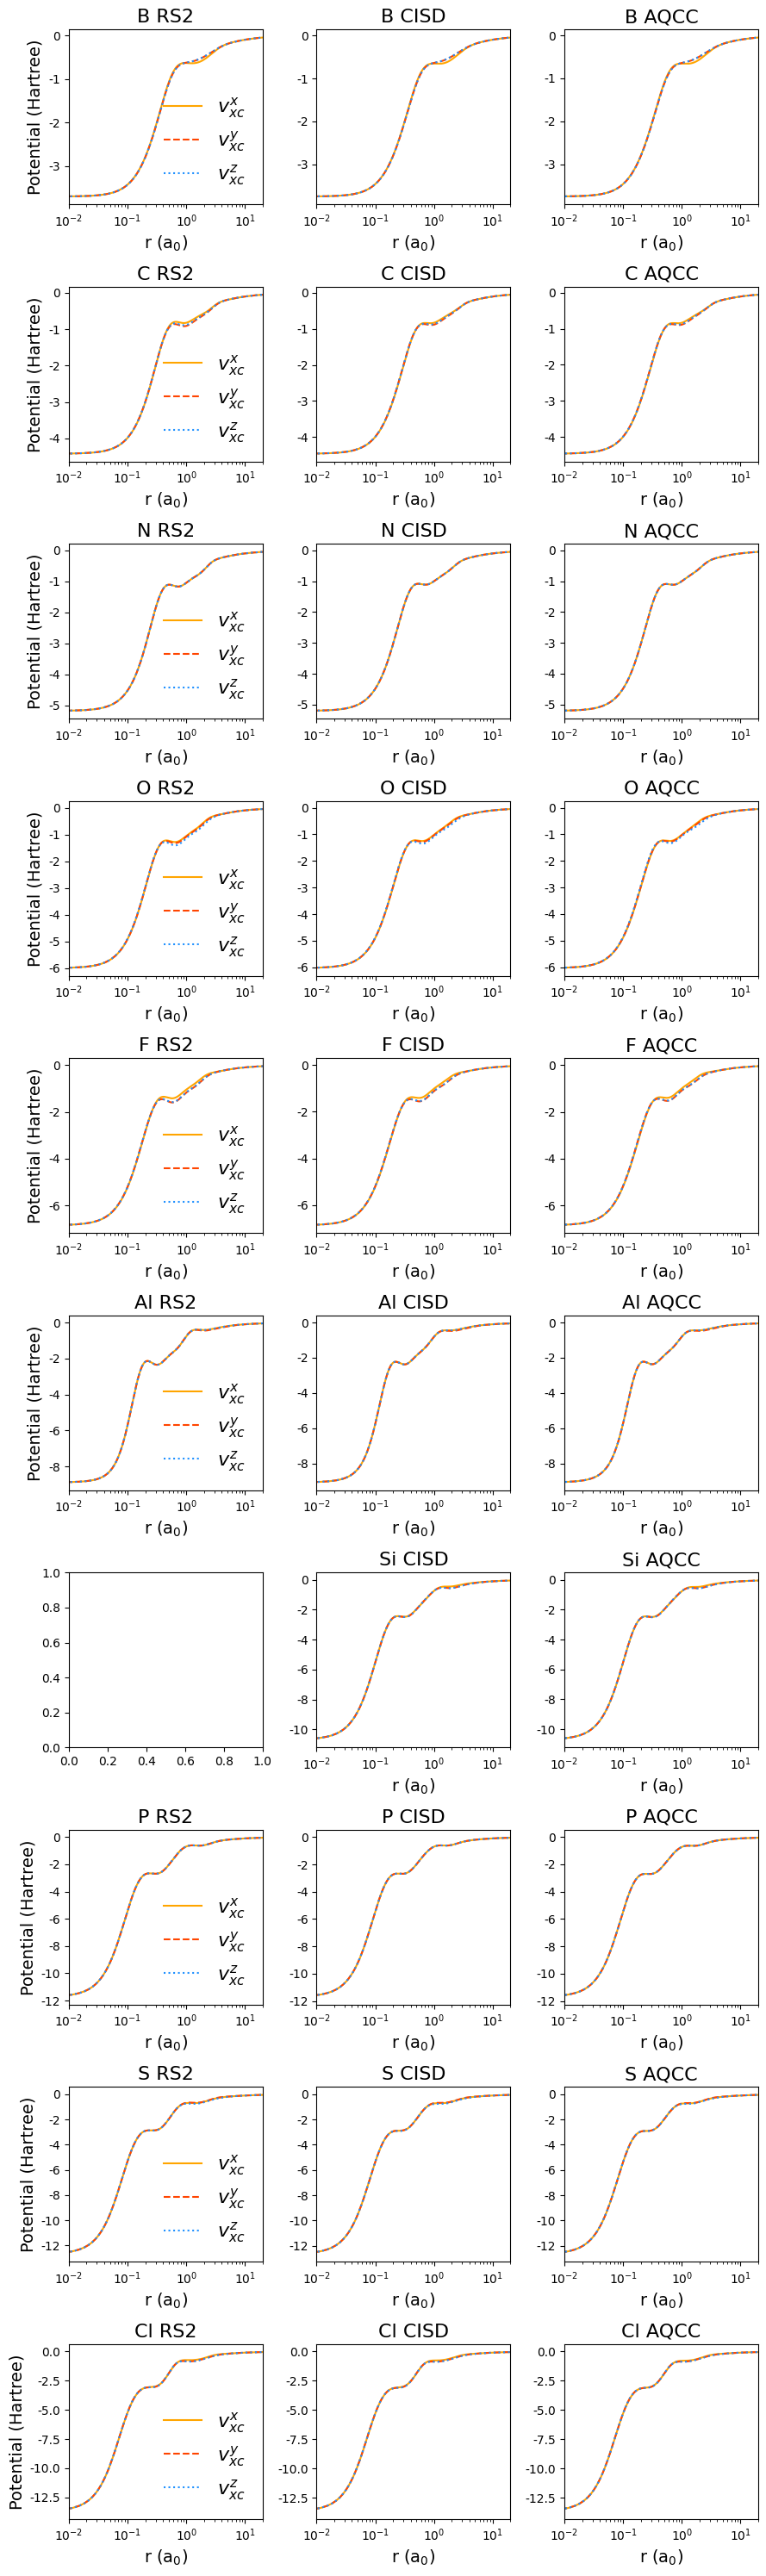

In [60]:
# Plot potentials
fig, axs = plt.subplots(10, 3, figsize=(9,30))

for i, system in enumerate(SYSTEMS):
    for j, ref in enumerate(REFERENCE):
        if system not in ["Si"] or ref not in ["RS2"]:
    
            axs[i, j].set_title(f"{system} {ref}", fontsize=16)

            if j == 0:
                axs[i, j].set_ylabel('Potential (Hartree)', fontsize=14)
            axs[i, j].set_xlabel('r (a$_0$)', fontsize=14)
            axs[i, j].set_xlim(0.01, 20.0)
            axs[i, j].set_xscale("log")
    
            coord = results[system][ref]["x"][0]
            pot = results[system][ref]["x"][1]
            axs[i, j].plot(coord, pot, '-', color="orange", label=r'$v_{xc}^x$')

            coord = results[system][ref]["y"][0]
            pot = results[system][ref]["y"][1]
            axs[i, j].plot(coord, pot, '--', color="orangered", label=r'$v_{xc}^y$')

            coord = results[system][ref]["z"][0]
            pot = results[system][ref]["z"][1]
            axs[i, j].plot(coord, pot, ':', color="dodgerblue", label=r'$v_{xc}^z$')
        
            if j == 0:
                axs[i, j].legend(frameon=False, fontsize=16, loc=4)
        
plt.tight_layout()
plt.show()

In [61]:
# Parse densities
results = {}
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        results[system][ref] = {}
        
        outfile = os.path.join(DATA_PATH, ref, system, "rho_ks-total-final.x")
        rhoks = load_vxc_den_ksinv(outfile, xyz=1)
        results[system][ref]["ks_x"] = rhoks  
        outfile = os.path.join(DATA_PATH, ref, system, "rho_ref-total-final.x")
        rhoref = load_vxc_den_ksinv(outfile, xyz=1)
        results[system][ref]["ref_x"] = rhoref  
        
        outfile = os.path.join(DATA_PATH, ref, system, "rho_ks-total-final.y")
        rhoks = load_vxc_den_ksinv(outfile, xyz=2)
        results[system][ref]["ks_y"] = rhoks 
        outfile = os.path.join(DATA_PATH, ref, system, "rho_ref-total-final.y")
        rhoref = load_vxc_den_ksinv(outfile, xyz=2)
        results[system][ref]["ref_y"] = rhoref  

        outfile = os.path.join(DATA_PATH, ref, system, "rho_ks-total-final.z")
        rhoks = load_vxc_den_ksinv(outfile, xyz=3)
        results[system][ref]["ks_z"] = rhoks 
        outfile = os.path.join(DATA_PATH, ref, system, "rho_ref-total-final.z")
        rhoref = load_vxc_den_ksinv(outfile, xyz=3)
        results[system][ref]["ref_z"] = rhoref

In [62]:
# Save pickle file with densities
with open('CLEAN_DATA/KSINV_CAHF_rho.pkl', "wb") as output_file:
    pickle.dump(results, output_file)

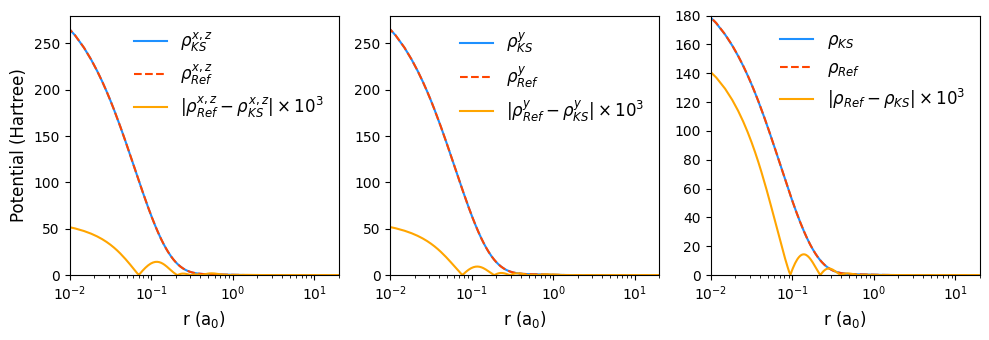

In [63]:
# Plot densities for testing

fig, axs = plt.subplots(1, 3, figsize=(10,3.5))

axs[0].set_xlim(0.01, 20.0)
axs[0].set_ylim(0.0, 280)
axs[0].set_xscale("log")

axs[1].set_xlim(0.01, 20.0)
axs[1].set_ylim(0.0, 280)
axs[1].set_xscale("log")

axs[2].set_xlim(0.01, 20.0)
axs[2].set_ylim(0.0, 180)
axs[2].set_xscale("log")

axs[0].set_xlabel('r (a$_0$)', fontsize=12)
axs[1].set_xlabel('r (a$_0$)', fontsize=12)
axs[2].set_xlabel('r (a$_0$)', fontsize=12)
axs[0].set_ylabel('Potential (Hartree)', fontsize=12)

coord = np.array(results["O"]["AQCC"]["ks_x"][0])
rhoks = np.array(results["O"]["AQCC"]["ks_x"][1])
rhoref = np.array(results["O"]["AQCC"]["ref_x"][1])
axs[0].plot(coord, rhoks, '-', color="dodgerblue", label=r'$\rho_{KS}^{x,z}$')
axs[0].plot(coord, rhoref, '--', color="orangered", label=r'$\rho_{Ref}^{x,z}$')
axs[0].plot(coord, abs(rhoks-rhoref)*1000, '-', color="orange", label=r'$|\rho_{Ref}^{x,z}-\rho_{KS}^{x,z}| \times 10^3$')
axs[0].legend(frameon=False, fontsize=12, loc=1)

coord = np.array(results["O"]["AQCC"]["ks_y"][0])
rhoks = np.array(results["O"]["AQCC"]["ks_y"][1])
rhoref = np.array(results["O"]["AQCC"]["ref_y"][1])
axs[1].plot(coord, rhoks, '-', color="dodgerblue", label=r'$\rho_{KS}^y$')
axs[1].plot(coord, rhoref, '--', color="orangered", label=r'$\rho_{Ref}^y$')
axs[1].plot(coord, abs(rhoks-rhoref)*1000, '-', color="orange", label=r'$|\rho_{Ref}^y-\rho_{KS}^y| \times 10^3$')
axs[1].legend(frameon=False, fontsize=12, loc=1)

coord = np.array(results["N"]["AQCC"]["ks_x"][0])
rhoks = np.array(results["N"]["AQCC"]["ks_x"][1])
rhoref = np.array(results["N"]["AQCC"]["ref_x"][1])
axs[2].plot(coord, rhoks, '-', color="dodgerblue", label=r'$\rho_{KS}$')
axs[2].plot(coord, rhoref, '--', color="orangered", label=r'$\rho_{Ref}$')
axs[2].plot(coord, abs(rhoks-rhoref)*1000, '-', color="orange", label=r'$|\rho_{Ref}-\rho_{KS}| \times 10^3$')
axs[2].legend(frameon=False, fontsize=12, loc=1)

plt.tight_layout()
plt.show()

## Processing of KSINV calculations with FCI target density

In [64]:
DATA_PATH = "RAW_OUTPUTS/KSINV_FCI"
SYSTEMS = ["B_aug-cc-pwCVTZ", "B_aug-cc-pwCVQZ", "C_aug-cc-pwCVTZ"]

In [65]:
# Parse eigenvalues and gaps
results = {}
for system in SYSTEMS:
    outfile = os.path.join(DATA_PATH, system, "output")
    results[system] = {}
    results[system]["eigenvalues"] = sorted(parse_eigenvalues(outfile, "KSINV eigenvalues"))
    a, b = parse_ksinv_gaps(outfile)
    results[system]["gaps"] = {"a": a, "b": b}

In [66]:
# Supplement eigenvalues by occupation numbers
for system in SYSTEMS:
    na = atoms[system[0]]["na"]
    nb = atoms[system[0]]["nb"]
    neigs = len(results[system]["eigenvalues"])
    occa = [1]*na
    occa.extend([0]*(neigs-na))
    occb = [1]*nb
    occb.extend([0]*(neigs-nb))
    occa[2] = 0
    occa[4] = 1
    occ = [occa[i]+occb[i] for i in range(len(occa))]
    results[system]["occ"] = occ

In [67]:
# Save data to json file
with open('CLEAN_DATA/KSINV_FCI_eigenvalues.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)

In [68]:
# Print occupation numbers and eigenvalues
print(f'B aug-cc-pwCVTZ {" "*4} B aug-cc-pwCVQZ {" "*4} C aug-cc-pwCVTZ')
for i in range(5):
    BT = f'{results["B_aug-cc-pwCVTZ"]["occ"][i]} {results["B_aug-cc-pwCVTZ"]["eigenvalues"][i]:8.3f}'
    BQ = f'{results["B_aug-cc-pwCVQZ"]["occ"][i]} {results["B_aug-cc-pwCVQZ"]["eigenvalues"][i]:8.3f}'
    CT = f'{results["C_aug-cc-pwCVTZ"]["occ"][i]} {results["C_aug-cc-pwCVTZ"]["eigenvalues"][i]:8.3f}'
    print(f"  {BT:20} {BQ:20} {CT:20}")

B aug-cc-pwCVTZ      B aug-cc-pwCVQZ      C aug-cc-pwCVTZ
  2   -6.876           2   -6.909           2  -10.311          
  2   -0.456           2   -0.500           2   -0.687          
  0   -0.252           0   -0.289           0   -0.386          
  0   -0.252           0   -0.289           1   -0.363          
  1   -0.246           1   -0.272           1   -0.363          


## Processing of EXX and KSINV calculations for comparision with inversion using FCI target density

In [69]:
DATA_PATH = "RAW_OUTPUTS/KSINV_FCI_Suppl"
SYSTEMS = ["B_aug-cc-pwCVTZ", "B_aug-cc-pwCVQZ", "C_aug-cc-pwCVTZ"]
REFERENCE = ["EXX", "RS2", "CISD", "AQCC"]

In [70]:
# Parse eigenvalues
results = {}
for system in SYSTEMS:
    results[system] = {}
    for ref in REFERENCE:
        results[system][ref] = {}
        
        outfile = os.path.join(DATA_PATH, system, ref, "output")
        
        if ref == "EXX":
            a, b = parse_exx_gaps(outfile)
        else:
            a, b = parse_ksinv_gaps(outfile)
        results[system][ref]["gaps"] = {"a": a, "b": b}
        
        if ref == "EXX":
            en = parse_en(outfile, "USCEXX Total energy")
        elif ref == "RS2":
            en = parse_en(outfile, "RSPT2 STATE 1.1 Energy")
        elif ref == "CISD":
            en = parse_en(outfile, "MRCI STATE 1.1 Energy")
        elif ref == "AQCC":
            en = parse_en(outfile, "AQCC STATE 1.1 Energy")
        results[system][ref]["en"] = en

In [71]:
# Save data to json file
with open('CLEAN_DATA/KSINV_FCI_Suppl.json', 'w', encoding='utf-8') as file_obj:
    json.dump(results, file_obj, ensure_ascii=False, indent=4)